First we install the loss function from the [Github repo](https://github.com/scandido/quantile-regression-tf), and then import packages.

In [ ]:
!pip install git+https://github.com/scandido/quantile-regression-tf.git

In [10]:
import matplotlib.pyplot as pl
import numpy as np
import tensorflow as tf
import tqdm
from quantile_regression_tf import QuantileLoss

To demonstrate using `QuantileLoss` to create a quantile regression, we create some arbitrary random process $y = f(x, r)$ where $r$ is a random variable.

In [11]:
def _f(x):
    return np.clip(np.random.lognormal(0.8, 0.09 * x) - 2.5, 0, None)

f = np.vectorize(_f)  # np.array([_f(x) for x in xs])

def sample_data(num_samples):
    xs = np.array([np.random.uniform(0, 10) for _ in range(num_samples)])
    ys = f(xs)  
    return xs, ys

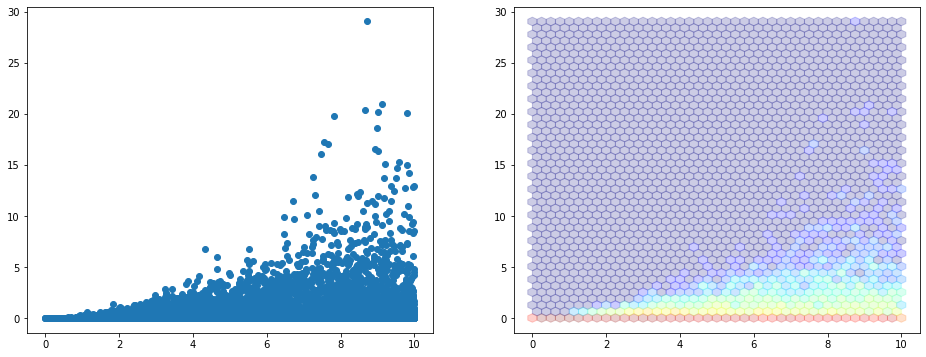

In [12]:
sample_x, sample_y = sample_data(num_samples=10000)

pl.figure(figsize=(16, 6))

pl.subplot(121)
pl.plot(sample_x, sample_y, 'o')

pl.subplot(122)
pl.hexbin(sample_x, sample_y, gridsize=40, cmap='jet', bins='log', alpha=0.2)

pl.show()

Now we create our deep quantile regression model. Start with a standard model and learning routine. 

Instead of our normal output layer with 1 head for the mean regression and using MSE for our loss, we use a dense layer with $n$ units for the $n$ quantiles. (Like normal regression this is a linear projection and we do not use an activation.) The neural network parameters holds our estimate of the value for `xx%` quantile.

We create a `QuantileLoss` object which holds the numeric values of the quantiles we want to regression on, e.g., `25%`, `50%`, and `75%`. In the example below we just pass the number of quantiles and the `QuantileLoss` chooses them to be evenly spaced.

The `QuantileLoss` object implements an efficient version of the classical quantile regression equations.

In [13]:
def sum_from_middle(t: tf.Tensor):
    d = len(t.shape) - 1
    knot = t.shape[-1] // 2
    a = tf.cumsum(t[..., :knot+1], axis=d, reverse=True)
    b = tf.cumsum(t[..., knot:], axis=d)
    return tf.concat([a[..., :-1], b], axis=d)


def mask_for_subtraction_and_addition(x: tf.Tensor):
    l = x.shape[-1]
    k = x.shape[-1] // 2
    m = tf.concat([-1 * tf.ones(l - k - 1), tf.ones(l - k)], axis=0)
    return m * x


class QuantileRegressionLearner(tf.keras.Model):
  def __init__(
      self,
      network_width: int = 20,
      num_hidden_layers: int = 2,
      num_quantiles: int = 21,
      learning_rate: float = 0.01,
      noncrossing: bool = False):
    super().__init__()

    self.noncrossing = noncrossing
    self.knot_point = num_quantiles // 2

    self.hidden_layers = [
        tf.keras.layers.Dense(units=network_width, activation=tf.nn.relu)
        for _ in range(num_hidden_layers)]

    self.quantile_layer = tf.keras.layers.Dense(
        units=num_quantiles, activation=None)
    self.quantile_loss = QuantileLoss(num_quantiles)

    self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  def call(self, x: np.ndarray, training: bool = False) -> tf.Tensor:
    for layer in self.hidden_layers:
      x = layer(x)
    x = self.quantile_layer(x)

    if not self.noncrossing:
        return x

    if not training:
        x = tf.nn.relu(x)

    x = mask_for_subtraction_and_addition(x)
    x = sum_from_middle(x)

    if not training:
        x = tf.nn.relu(x)

    return x
    

  def train(self, xs: np.ndarray, ys: np.ndarray) -> float:
    with tf.GradientTape() as tape:
      xs = np.expand_dims(xs, axis=1)
      ys = np.expand_dims(ys, axis=1)
      yp = self(xs, training=True)
      loss = self.quantile_loss(ys, yp)
      gradients = tape.gradient(loss, self.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    return float(np.mean(loss))

  def plot(self, xs: np.ndarray, ys: np.ndarray) -> None:
    xr = np.linspace(0, 10, 21)
    xr = np.expand_dims(xr, axis=1)
    yr = self(xr)
    xr = np.squeeze(xr)
    yr = np.squeeze(yr)
    pl.hexbin(xs, ys, gridsize=40, cmap='jet', bins='log', alpha=.2)
    for quantile, label in enumerate(self.quantile_loss.quantile_labels()):
      pl.plot(xr, yr[:, quantile], label=label)
    pl.legend(bbox_to_anchor=(1.3, 1.2))
    pl.show()

Train for a little bit, and then we can visualize the learned quantile values.

100%|██████████| 20000/20000 [06:08<00:00, 54.35it/s]


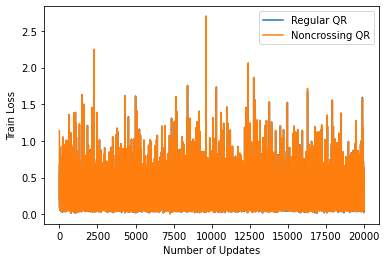

In [14]:
model_regular = QuantileRegressionLearner()
model_noncrossing = QuantileRegressionLearner(noncrossing=True)

loss_regular = []
loss_noncrossing = []
for _ in tqdm.tqdm(range(20000)):
    batch = sample_data(num_samples=12)
    loss_regular.append(model_regular.train(*batch))
    loss_noncrossing.append(model_noncrossing.train(*batch))

pl.plot(loss_regular, label='Regular QR')
pl.plot(loss_noncrossing, label='Noncrossing QR')
pl.legend()
pl.xlabel('Number of Updates')
pl.ylabel('Train Loss')
pl.show()

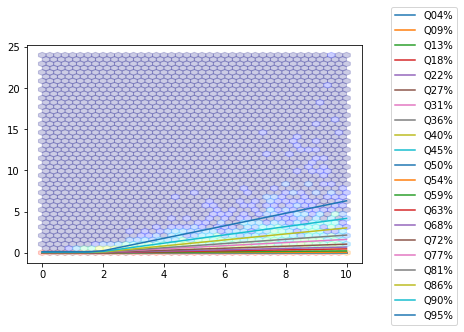

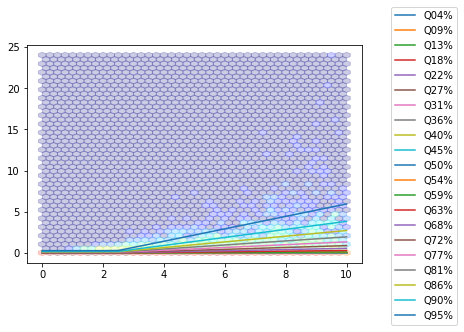

In [15]:
samples = sample_data(num_samples=5000)
model_regular.plot(*samples)
model_noncrossing.plot(*samples)

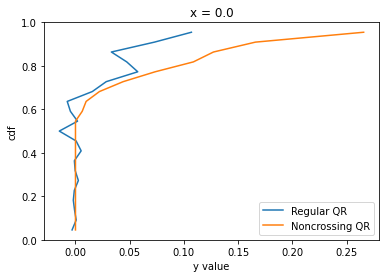

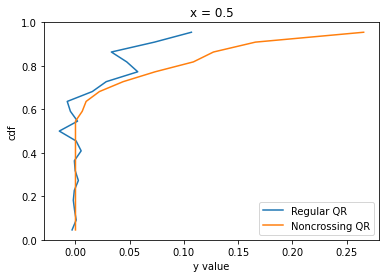

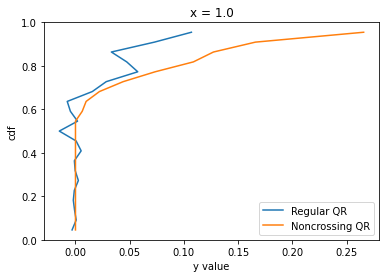

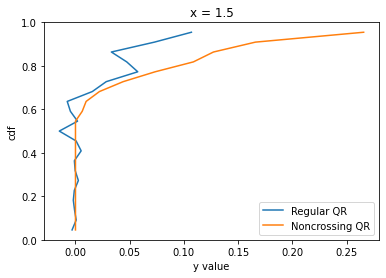

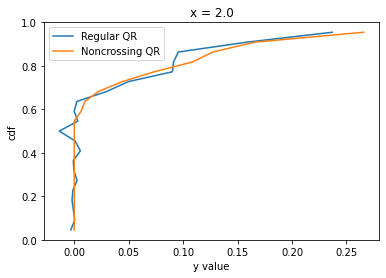

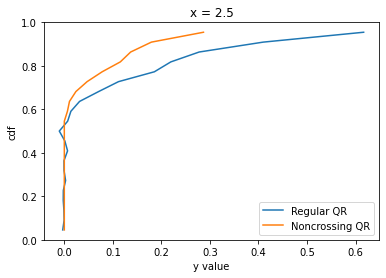

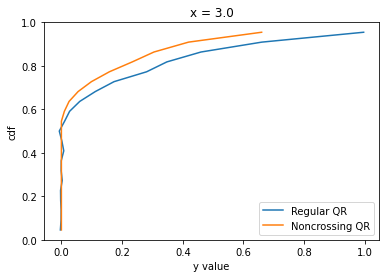

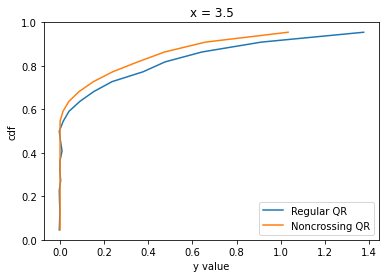

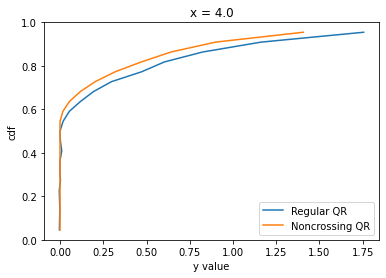

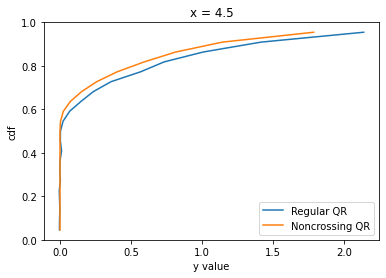

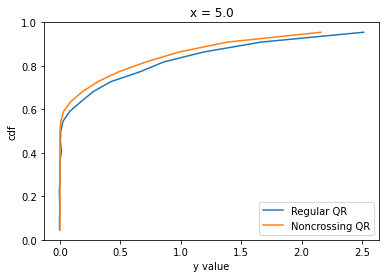

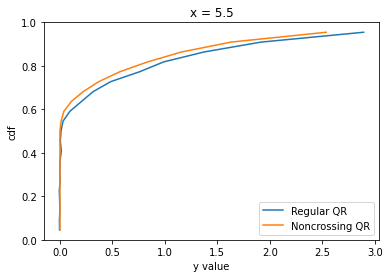

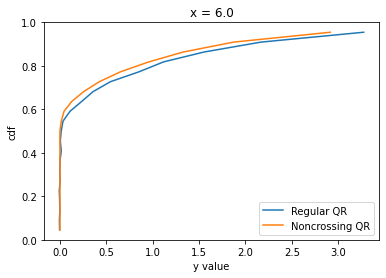

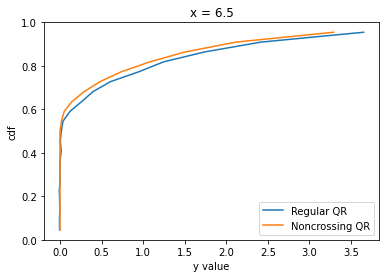

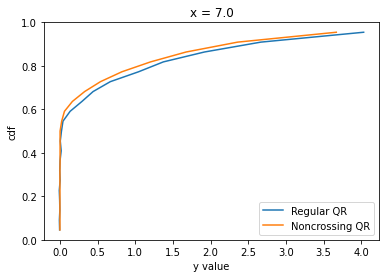

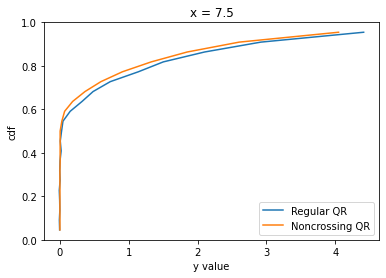

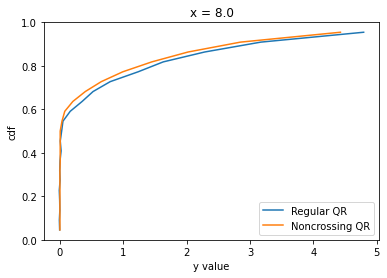

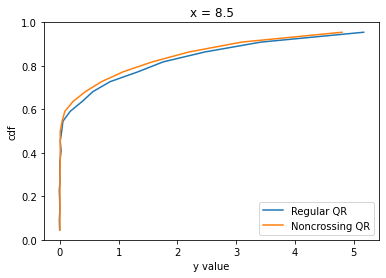

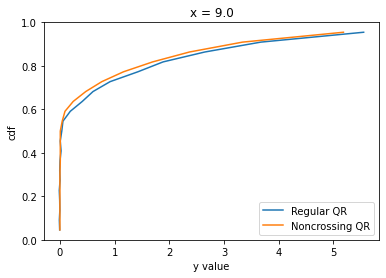

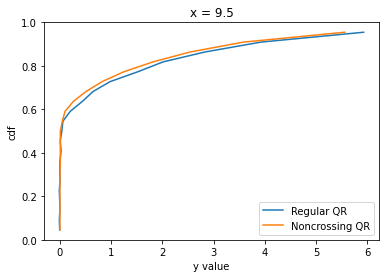

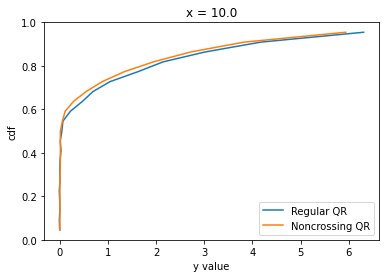

In [16]:
xr = np.linspace(0, 10, 21)
xr = np.expand_dims(xr, axis=1)
yr_regular = model_regular(xr)
yr_noncrossing = model_noncrossing(xr)
xr = np.squeeze(xr)
yr_regular = np.squeeze(yr_regular)
yr_noncrossing = np.squeeze(yr_noncrossing)

for i, x in enumerate(xr):
    pl.plot(yr_regular[i], model_regular.quantile_loss.quantiles, label='Regular QR')
    pl.plot(yr_noncrossing[i], model_noncrossing.quantile_loss.quantiles, label='Noncrossing QR')

    pl.legend()
    pl.xlabel('y value')
    pl.ylabel('cdf')
    pl.title(f'x = {x}')
    pl.show()